<a href="https://colab.research.google.com/github/mohitraosatya/toeplitz-quantum-extractor/blob/main/Toeplitz%E2%80%91Quantum%E2%80%91Extractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# Cell 1 – setup
!pip install bitarray scipy tqdm --quiet

import numpy as np
from bitarray import bitarray
import matplotlib.pyplot as plt
from math import log2
from tqdm.auto import tqdm

from scipy.signal import fftconvolve
import scipy.special as sps  # for frequency & runs tests


In [25]:
# Cell 2 – helpers

def bytes_to_bits(b: bytes) -> bitarray:
    ba = bitarray(endian='big')
    ba.frombytes(b)
    return ba

def random_bitarray(length: int, bias=0.5) -> bitarray:
    bits = np.random.rand(length) < bias
    return bitarray(bits.tolist())

def xor_bits(a: bitarray, b: bitarray) -> bitarray:
    assert len(a) == len(b)
    return a ^ b

def min_entropy(bits: bitarray, window=None):
    if window is None:
        p1 = bits.count() / len(bits)
        return -log2(max(p1, 1 - p1))
    hes = []
    for i in range(0, len(bits) - window + 1, window):
        chunk = bits[i:i+window]
        p1 = chunk.count() / window
        hes.append(-log2(max(p1, 1 - p1)))
    return np.mean(hes)


In [26]:
# Cell 3 – raw QRNG (slightly biased)
N_BITS = 1_000_000           # adjust if RAM is tight
sourceA = random_bitarray(N_BITS, bias=0.502)
sourceB = random_bitarray(N_BITS, bias=0.498)

print("Source A min‑entropy:", min_entropy(sourceA))
print("Source B min‑entropy:", min_entropy(sourceB))


Source A min‑entropy: 0.9968986561224182
Source B min‑entropy: 0.9906929628853469


In [27]:
# Cell 4 – fusion
fused = xor_bits(sourceA, sourceB)
print("Fused min‑entropy:", min_entropy(fused))


Fused min‑entropy: 0.9988809028018468


In [28]:
# Cell 5 – von Neumann debiasing
def von_neumann(bits):
    out = bitarray()
    # group pairs 00 01 10 11
    for i in range(0, len(bits) - 1, 2):
        pair = bits[i:i+2]
        if pair == bitarray('01'):
            out.append(False)
        elif pair == bitarray('10'):
            out.append(True)
    return out

vn = von_neumann(fused)
print(f"von Neumann output length: {len(vn)}")
print("von Neumann min‑entropy:", min_entropy(vn))


von Neumann output length: 250548
von Neumann min‑entropy: 0.9981815684775092


In [29]:
# Cell 6 – Toeplitz convolution in GF(2) via FFT
def toeplitz_dot(seed_bits, raw_bits, out_len):
    """
    Streaming Toeplitz extractor using FFT‑based convolution in GF(2).
    Works in O(L log L) time and linear RAM (~2–3 × input size).
    """
    n = len(raw_bits)
    m = out_len
    k = m + n - 1                                 # seed length

    # Ensure numpy int8 arrays (0/1 values)
    s = np.asarray(seed_bits[:k],  dtype=np.int8)
    r = np.asarray(raw_bits,      dtype=np.int8)

    # FFT‑based convolution (real domain); round then mod‑2
    conv = fftconvolve(s, r, mode="full")
    conv = np.round(conv).astype(np.int8) & 1

    start = n - 1                                 # first valid Toeplitz output
    return bitarray(conv[start:start + m].tolist())


In [30]:
# Cell 7 – run extractor
OUT_LEN = int(len(fused) * 0.6)                       # 60 % compression

seed_bits = np.random.randint(0, 2,
                              OUT_LEN + len(fused) - 1,
                              dtype=np.int8)

out_bits = toeplitz_dot(seed_bits, fused.tolist(), OUT_LEN)

print("Toeplitz output bits:", len(out_bits))
print("Toeplitz min‑entropy:", min_entropy(out_bits))


Toeplitz output bits: 600000
Toeplitz min‑entropy: 0.9979672327567117


In [32]:
# Cell 8 – basic NIST‑style tests
def frequency_test(bits):
    s = 2*bits.count() - len(bits)
    return sps.erfc(abs(s) / (np.sqrt(len(bits))*np.sqrt(2)))

def runs_test(bits):
    pi = bits.count() / len(bits)
    if abs(pi - 0.5) > 2/np.sqrt(len(bits)):
        return 0.0
    runs = 1 + sum(bits[i] != bits[i+1] for i in range(len(bits)-1))
    expected = 2*len(bits)*pi*(1 - pi)
    return sps.erfc(
        abs(runs - expected) /
        (2*np.sqrt(2*len(bits))*pi*(1 - pi))
    )

print("Frequency p‑value:", frequency_test(out_bits))
print("Runs p‑value     :", runs_test(out_bits))


Frequency p‑value: 0.2747534186154179
Runs p‑value     : 0.7031341662976892


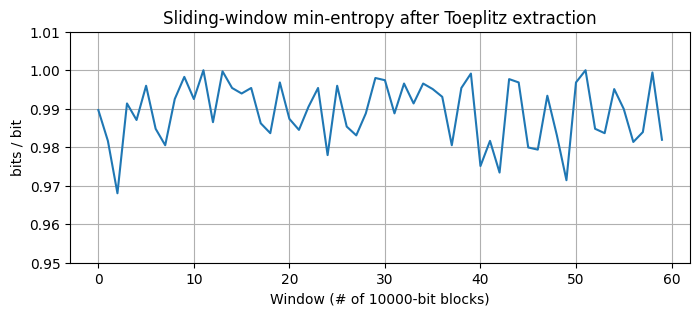

In [33]:
# Cell 9 – plot entropy per window
WINDOW = 10_000
windows = []
hes = []
for i in range(0, len(out_bits) - WINDOW + 1, WINDOW):
    windows.append(i//WINDOW)
    hes.append(min_entropy(out_bits[i:i+WINDOW]))

plt.figure(figsize=(8,3))
plt.plot(windows, hes)
plt.title("Sliding‑window min‑entropy after Toeplitz extraction")
plt.ylabel("bits / bit")
plt.xlabel(f"Window (# of {WINDOW}‑bit blocks)")
plt.ylim(0.95, 1.01)
plt.grid(True)
plt.show()
